# Finpros - Vòng 2 - Bài Test thực hành (TPHCM)

Libraries

In [1]:
#Data Prrocessing
import math
import pandas as pd
import datetime as dt
import numpy as np
from bisect import bisect_right

#Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

#Predictions
import tensorflow as tf
tf.config.list_physical_devices('GPU')

from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from keras.models import load_model
from keras.models import save_model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import scipy.stats as stats
from scipy.signal import periodogram
from scipy.special import inv_boxcox

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Table of Content
- [LOAD DATA](#Load-Data)
- [DATA ANALYSIS](#Data-Analysis)
- [DATA PREPROCESSING](#Data-Preprocessing)
- [BULDING MODEL](#Building-Model)
- [EVALUATION AND TESTING](#Evaluation-and-Testing)
- [TESTING THE OTHERS COMPANY](#Testing-on-the-others-company)

## CHOOSE THE COMPANY

In [2]:
company = "PNJ"

## LOAD DATA

In [3]:
# read FPT data
df = pd.read_csv(f"{company}.csv")
df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2/28/2018 9:15,78.14,78.99,78.14,78.99,270,0
1,PNJ,2/28/2018 9:16,78.94,78.94,78.94,78.94,10,0
2,PNJ,2/28/2018 9:19,78.14,78.14,78.14,78.14,283,0
3,PNJ,2/28/2018 9:20,78.14,78.14,78.14,78.14,480,0
4,PNJ,2/28/2018 9:21,78.14,78.14,78.14,78.14,146,0
...,...,...,...,...,...,...,...,...
125304,PNJ,12/22/2020 14:22,78.20,78.20,78.20,78.20,5000,0
125305,PNJ,12/22/2020 14:23,78.20,78.20,78.20,78.20,1700,0
125306,PNJ,12/22/2020 14:24,78.20,78.20,78.20,78.20,870,0
125307,PNJ,12/22/2020 14:25,78.10,78.10,78.10,78.10,13000,0


In [4]:
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2/28/2018 9:15,78.14,78.99,78.14,78.99,270,0
1,PNJ,2/28/2018 9:16,78.94,78.94,78.94,78.94,10,0
2,PNJ,2/28/2018 9:19,78.14,78.14,78.14,78.14,283,0
3,PNJ,2/28/2018 9:20,78.14,78.14,78.14,78.14,480,0
4,PNJ,2/28/2018 9:21,78.14,78.14,78.14,78.14,146,0


In [5]:
df.describe()

,Open,High,Low,Close,Volume,Open Interest
count,125309.000000,125309.000000,125309.000000,125309.000000,125309.000000,125309.0
mean,72.182052,72.372590,72.042287,72.179371,3031.830451,0.0
std,9.900263,9.995786,9.830847,9.899401,7248.952968,0.0
min,44.430000,44.530000,44.040000,44.140000,1.000000,0.0
25%,64.600000,64.700000,64.570000,64.600000,220.000000,0.0
50%,72.800000,73.010000,72.640000,72.830000,1000.000000,0.0
75%,80.160000,80.350000,80.060000,80.160000,3130.000000,0.0
max,100.160000,100.160000,100.160000,100.160000,580730.000000,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125309 entries, 0 to 125308
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         125309 non-null  object 
 1   Date/Time      125309 non-null  object 
 2   Open           125309 non-null  float64
 3   High           125309 non-null  float64
 4   Low            125309 non-null  float64
 5   Close          125309 non-null  float64
 6   Volume         125309 non-null  int64  
 7   Open Interest  125309 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 7.6+ MB


## DATA ANALYSIS

In [7]:
# ADF test function

def adf_test(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

Results of Augmented Dickey-Fuller Test:
Test Statistic                     -1.957978
p-value                             0.305297
Lags Used                          43.000000
Number of Observations Used    125265.000000
Critical Value (1%)                -3.430402
Critical Value (5%)                -2.861563
Critical Value (10%)               -2.566782
dtype: float64


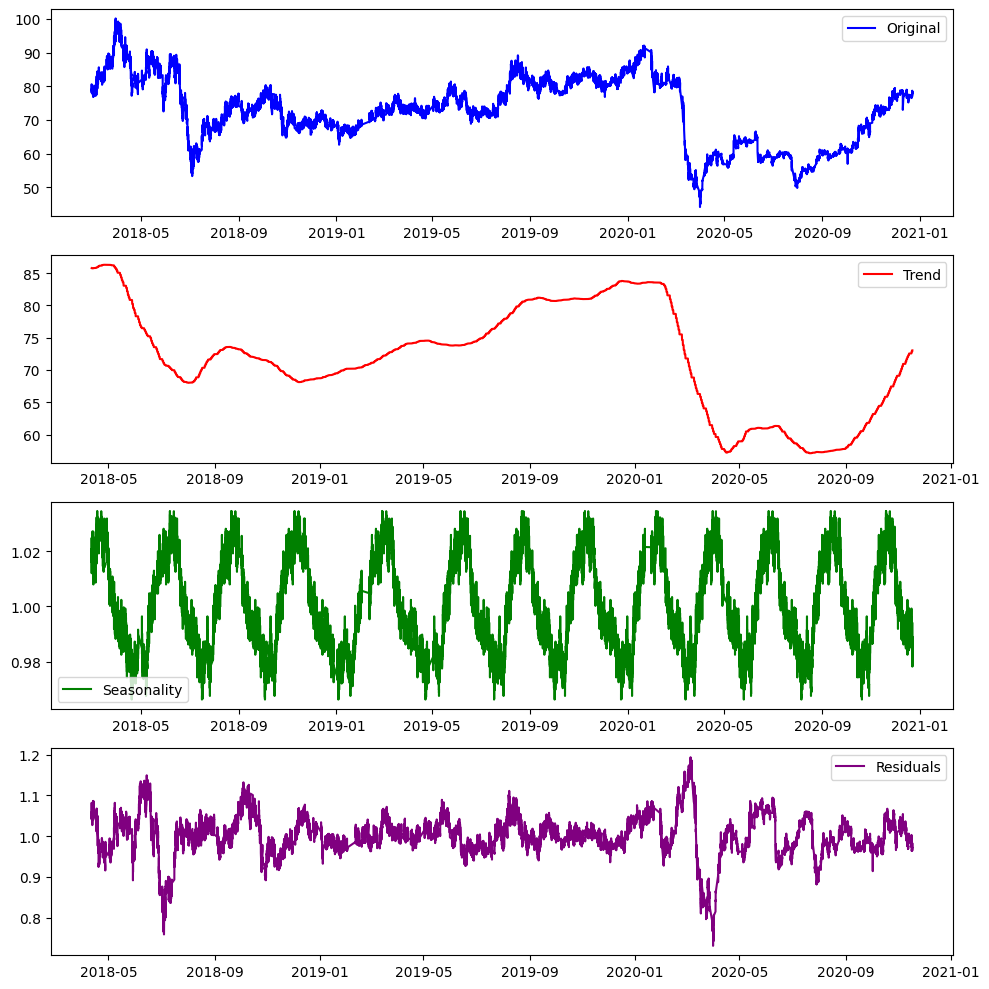

In [8]:
# Time-series analysis

df['Date/Time'] = pd.to_datetime(df['Date/Time'])
plt_df = df.set_index('Date/Time')

decomposition = sm.tsa.seasonal_decompose(plt_df['Close'], model='multiplicative', period=10000)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 10))
plt.subplot(411)
plt.plot(plt_df['Close'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='purple')
plt.legend(loc='best')
plt.tight_layout()

adf_test(plt_df['Close'])

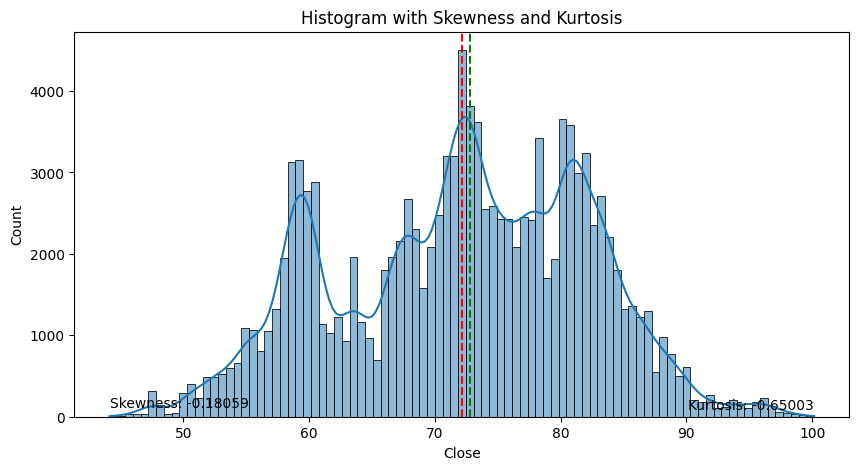

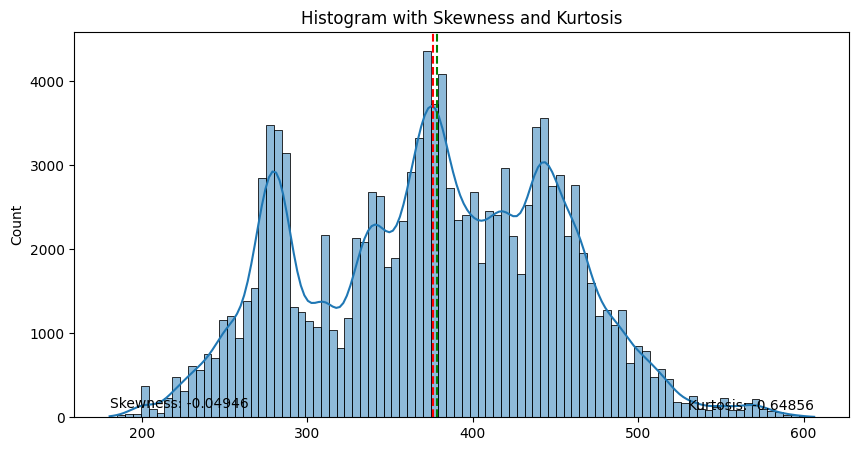

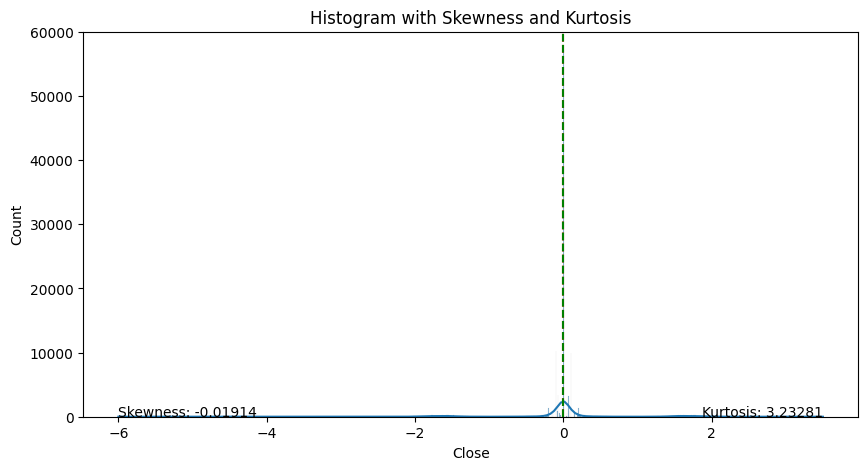

In [9]:
# Scaler Testing

plt.figure(figsize=(10,5))
sns.histplot(plt_df['Close'], kde=True)
plt.title('Histogram with Skewness and Kurtosis')
plt.axvline(plt_df['Close'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(plt_df['Close'].median(), color='green', linestyle='dashed', linewidth=1.5)
plt.text(min(plt_df['Close']), 110, f"Skewness: {stats.skew(plt_df['Close']):.5f}", ha='left', fontsize=10)
plt.text(max(plt_df['Close']), 90, f"Kurtosis: {stats.kurtosis(plt_df['Close']):.5f}", ha='right', fontsize=10)

data_boxcox, lambda_boxcox = stats.boxcox(df['Close'])
skewness_boxcox = stats.skew(data_boxcox)
kurtosis_boxcox = stats.kurtosis(data_boxcox)

plt.figure(figsize=(10,5))
sns.histplot(data_boxcox, kde=True)
plt.title('Histogram with Skewness and Kurtosis')
plt.axvline(np.mean(data_boxcox), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(np.median(data_boxcox), color='green', linestyle='dashed', linewidth=1.5)
plt.text(min(data_boxcox), 110, f"Skewness: {stats.skew(data_boxcox):.5f}", ha='left', fontsize=10)
plt.text(max(data_boxcox), 90, f"Kurtosis: {stats.kurtosis(data_boxcox):.5f}", ha='right', fontsize=10)

data_diff = plt_df['Close'].diff().dropna()
plt.figure(figsize=(10,5))
sns.histplot(data_diff, kde=True)
plt.title('Histogram with Skewness and Kurtosis')
plt.axvline(data_diff.mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(data_diff.median(), color='green', linestyle='dashed', linewidth=1.5)
plt.text(min(data_diff), 110, f"Skewness: {stats.skew(data_diff):.5f}", ha='left', fontsize=10)
plt.text(max(data_diff), 90, f"Kurtosis: {stats.kurtosis(data_diff):.5f}", ha='right', fontsize=10)

plt.show()

## DATA PREPROCESSING

In [10]:
# Calculate the best cycles 

df_2019 = df[df['Date/Time'].dt.year == 2019]
MA = [len(df_2019), len(df_2019)/2, len(df_2019)/3, len(df_2019)/12, len(df_2019)/12/4, len(df_2019)/12/4/7, len(df_2019)/12/4/7/7, len(df_2019)/12/4/7/7/7]
MA = [math.floor(x) for x in MA]
f, Pxx = periodogram(df['Close'])
highest_indices = np.argsort(Pxx)[::-1]
highest_freqs = f[highest_indices]
epsilon = np.finfo(float).eps
highest_periods = np.round(1 / (highest_freqs + epsilon))
valid_indices = np.isfinite(highest_periods)
highest_periods = highest_periods[valid_indices].astype(int)
highest_periods = sorted(highest_periods)
result = []
for ma in MA:
    index = bisect_right(highest_periods, ma) - 1
    if index >= 0:
        result.append(highest_periods[index])
    else:
        result.append(None)
MA = result

C:\Users\nguye\AppData\Local\Temp\ipykernel_9220\3679747667.py:12: RuntimeWarning: invalid value encountered in cast
  highest_periods = highest_periods[valid_indices].astype(int)


In [11]:
# Standardazation data

box_open, lambda_close = stats.boxcox(df['Open'].ravel())
box_high, lambda_close = stats.boxcox(df['High'].ravel())
box_low, lambda_close = stats.boxcox(df['Low'].ravel())
box_close, lambda_close = stats.boxcox(df['Close'].ravel())

df['Open'] = box_open
df['High'] = box_high
df['Low'] = box_low
df['Close'] = box_close

df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']

for i in range(len(MA)):
    df[f'ME_{i + 1}'] = df['Close'].rolling(window = MA[i]).median()
    df[f'RANK_{i + 1}'] = df['Close'].rolling(window = MA[i]).rank() 
    df[f'VAR_{i + 1}'] = df['Close'].rolling(window = MA[i]).var()
    df[f'MA_{i + 1}'] = df['Close'].rolling(window = MA[i]).mean()
    df[f'STD_{i + 1}'] = df['Close'].rolling(window = MA[i]).std()
    
df.fillna(method='bfill', inplace=True)
df.dropna(inplace = True)
df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,H-L,O-C,...,ME_7,RANK_7,VAR_7,MA_7,STD_7,ME_8,RANK_8,VAR_8,MA_8,STD_8
0,PNJ,2018-02-28 09:15:00,418.545355,410.300607,443.355820,426.962996,270,0,-33.055213,-8.417640,...,425.047104,7.0,14.575130,424.207926,3.817739,426.763309,1.0,0.079749,426.763309,0.282399
1,PNJ,2018-02-28 09:16:00,424.889423,409.919591,450.146879,426.563623,10,0,-40.227289,-1.674200,...,425.047104,7.0,14.575130,424.207926,3.817739,426.763309,1.0,0.079749,426.763309,0.282399
2,PNJ,2018-02-28 09:19:00,418.545355,403.838608,443.355820,420.190046,283,0,-39.517212,-1.644690,...,425.047104,7.0,14.575130,424.207926,3.817739,423.376834,1.0,20.311241,423.376834,4.506799
3,PNJ,2018-02-28 09:20:00,418.545355,403.838608,443.355820,420.190046,480,0,-39.517212,-1.644690,...,425.047104,7.0,14.575130,424.207926,3.817739,420.190046,1.5,0.000000,420.190046,0.000000
4,PNJ,2018-02-28 09:21:00,418.545355,403.838608,443.355820,420.190046,146,0,-39.517212,-1.644690,...,425.047104,7.0,14.575130,424.207926,3.817739,420.190046,1.5,0.000000,420.190046,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125304,PNJ,2020-12-22 14:22:00,419.020096,404.293682,443.863973,420.666992,5000,0,-39.570290,-1.646896,...,420.666992,6.5,0.139522,420.900903,0.373526,421.064641,1.0,0.316249,421.064641,0.562360
125305,PNJ,2020-12-22 14:23:00,419.020096,404.293682,443.863973,420.666992,1700,0,-39.570290,-1.646896,...,420.666992,6.5,0.139522,420.900903,0.373526,420.666992,1.5,0.000000,420.666992,0.000000
125306,PNJ,2020-12-22 14:24:00,419.020096,404.293682,443.863973,420.666992,870,0,-39.570290,-1.646896,...,420.666992,6.5,0.139522,420.900903,0.373526,420.666992,1.5,0.000000,420.666992,0.000000
125307,PNJ,2020-12-22 14:25:00,418.228958,403.535316,443.017158,419.872178,13000,0,-39.481843,-1.643221,...,420.666992,1.0,0.199922,420.854150,0.447126,420.269585,1.0,0.315865,420.269585,0.562018


In [12]:
# Scaling features

scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))

cols_x= [col for col in df.columns if col not in ['Open', 'High', 'Low', 'Close', 'Date/Time', 'Ticker', 'Open Interest']]
cols_y = ['Close']
scaled_data_x = scaler_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x))) 
scaled_data_y = scaler_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

In [13]:
# Featuring data

pre_h = 7
X_total = [] 
y_total = [] 
for i in range(pre_h, len(df)):
    X_total.append(scaled_data_x[i - pre_h : i])
    y_total.append(scaled_data_y[i])

## BUILDING MODEL

In [14]:
# Split training set and testing set 

test_size = int(len(df)*0.1)
    
X_train = np.array(X_total[:len(X_total)-test_size]) 
y_train = np.array(y_total[:len(y_total)-test_size]) 

X_test = np.array(X_total[len(X_total)-test_size:]) 
y_test = np.array(y_total[len(y_total)-test_size:]) 

In [15]:
# Create LSTM model 

def CreateModel(cells):
    model = Sequential()
    model.add(LSTM(units = cells, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(LSTM(units = cells, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(LSTM(units = cells, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(LSTM(units = cells, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(LSTM(units = cells, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(LSTM(units = cells))
    model.add(Dropout(0.1))
    model.add(Dense(units = len(cols_y)))                     
    return model

In [16]:
model = CreateModel(387)

model.compile(optimizer = Adam(learning_rate = 0.00001), loss = 'mean_squared_error', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs= 10, batch_size= 85, use_multiprocessing= True, validation_split= 0.2, shuffle= True)

save_model(model, f"model/{company}.h5", include_optimizer = True)

Epoch 1/10
1062/1062 [==============================] - 31s 20ms/step - loss: 0.0230 - accuracy: 3.3253e-05 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2/10
1062/1062 [==============================] - 20s 19ms/step - loss: 6.4292e-04 - accuracy: 3.3253e-05 - val_loss: 5.6820e-04 - val_accuracy: 0.0000e+00
Epoch 3/10
1062/1062 [==============================] - 22s 21ms/step - loss: 5.4284e-04 - accuracy: 3.3253e-05 - val_loss: 4.1934e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
1062/1062 [==============================] - 24s 23ms/step - loss: 4.8331e-04 - accuracy: 3.3253e-05 - val_loss: 4.5602e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1062/1062 [==============================] - 24s 22ms/step - loss: 4.4258e-04 - accuracy: 3.3253e-05 - val_loss: 4.0722e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
1062/1062 [==============================] - 22s 21ms/step - loss: 4.1674e-04 - accuracy: 3.3253e-05 - val_loss: 4.1179e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
1062/1062 [==============

## EVALUATION AND TESTING

392/392 [==============================] - 4s 7ms/step


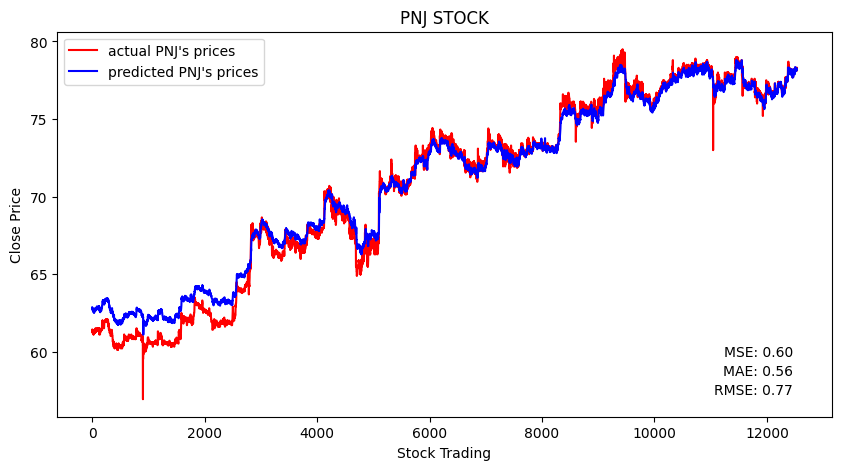

In [17]:
# Predict on test

actual_prices = y_test
actual_prices = scaler_y.inverse_transform(actual_prices)
actual_prices = inv_boxcox(actual_prices, lambda_boxcox)

predict_prices = model.predict(X_test)
predict_prices = scaler_y.inverse_transform(predict_prices)
predict_prices = inv_boxcox(predict_prices, lambda_boxcox)

ig, ax = plt.subplots(figsize=(10, 5))
ax.plot(actual_prices, color="red", label=f"actual {company}'s prices")
ax.plot(predict_prices, color="blue", label=f"predicted {company}'s prices")
ax.set_title(f"{company} STOCK")
ax.set_xlabel("Stock Trading")
ax.set_ylabel("Close Price")
ax.legend()

rmse = mean_squared_error(actual_prices, predict_prices, squared=False)
mae = mean_absolute_error(actual_prices,  predict_prices)
mse = mean_squared_error(actual_prices, predict_prices)

plt.text(0.95, 0.05, f"RMSE: {rmse:.2f}", transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom')
plt.text(0.95, 0.10, f"MAE: {mae:.2f}", transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom')
plt.text(0.95, 0.15, f"MSE: {mse:.2f}", transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom')

plt.show()

3525/3525 [==============================] - 21s 6ms/step


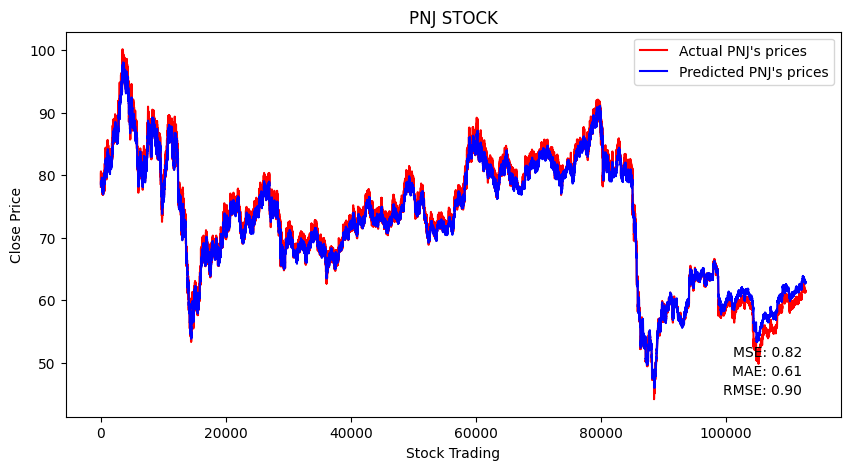

In [18]:
# Predict on train

actual_prices = y_train
actual_prices = scaler_y.inverse_transform(actual_prices)
actual_prices = inv_boxcox(actual_prices, lambda_boxcox)

predict_prices = model.predict(X_train)
predict_prices = scaler_y.inverse_transform(predict_prices)
predict_prices = inv_boxcox(predict_prices, lambda_boxcox)

ig, ax = plt.subplots(figsize=(10, 5))
ax.plot(actual_prices, color="red", label=f"Actual {company}'s prices")
ax.plot(predict_prices, color="blue", label=f"Predicted {company}'s prices")
ax.set_title(f"{company} STOCK")
ax.set_xlabel("Stock Trading")
ax.set_ylabel("Close Price")
ax.legend()

rmse = mean_squared_error(actual_prices, predict_prices, squared=False)
mae = mean_absolute_error(actual_prices,  predict_prices)
mse = mean_squared_error(actual_prices, predict_prices)

plt.text(0.95, 0.05, f"RMSE: {rmse:.2f}", transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom')
plt.text(0.95, 0.10, f"MAE: {mae:.2f}", transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom')
plt.text(0.95, 0.15, f"MSE: {mse:.2f}", transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom')

plt.show()

## MAKE PREDICTION

1/1 [==============================] - 0s 22ms/step


(0.0, 93.96)

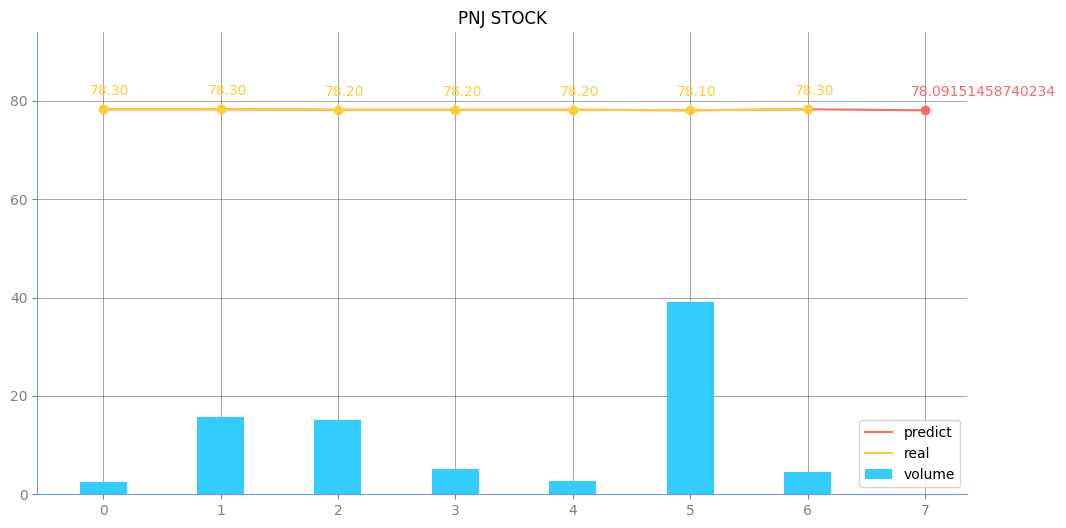

In [19]:
# Configuration price for prediction
x_predict = df[len(df)-7:][cols_x].values.reshape(-1, len(cols_x))
x_predict = scaler_x.transform(x_predict)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(1, x_predict.shape[0], len(cols_x))

# Get prediction
prediction = model.predict(x_predict)
prediction = scaler_y.inverse_transform(prediction)

# Get real price
df = pd.read_csv(f"{company}.csv", usecols = ['Close', 'Volume'])
real_prices = df.loc[len(df)-7:, ['Close', 'Volume']]
real_prices = np.array(real_prices)

predict_prices = real_prices[:, 0]
predict_prices = np.append(predict_prices , inv_boxcox(prediction, lambda_boxcox))

font = "Segoe UI"  
font_color = "gray"  
fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(True, linewidth=0.5, color='gray', zorder=1)
if predict_prices[6] < predict_prices[7]:
    ax.plot(predict_prices, color="#58D68D", label=f"predict", zorder=2)
else:
    ax.plot(predict_prices, color="#FF6666", label=f"predict", zorder=2)
ax.plot(real_prices[:, 0], color="#FFCC33", label=f"real", zorder=2)
real_volumes = np.multiply(real_prices[:, 1], (np.max(predict_prices)/2/(np.max(real_prices[:, 1]))))
x = np.arange(len(real_volumes))  
width = 0.4  
ax.bar(x - width/2, real_volumes , width, color="#33CCFF", label='volume', align='edge', zorder=2)
ax.scatter(np.arange(len(real_prices[:, 0])), real_prices[:, 0], color='#FFCC33', zorder=2)
for i, price in enumerate(real_prices[:, 0]):
    ax.annotate(f"{price:.2f}", (i, real_prices[i, 0]), xytext=(5, 10), textcoords='offset points', color='#FFCC33', ha='center', zorder=2)
if predict_prices[6] < predict_prices[7]:
    ax.scatter(len(predict_prices)-1, predict_prices[-1], color="#58D68D", zorder=2)
    ax.annotate(predict_prices[-1], xy=(len(predict_prices)-1, predict_prices[-1]), xytext=(-10, 10), textcoords='offset points', color="#58D68D",zorder=2 )
else:
    ax.scatter(len(predict_prices)-1, predict_prices[-1], color="#FF6666", zorder=2)
    ax.annotate(predict_prices[-1], xy=(len(predict_prices)-1, predict_prices[-1]), xytext=(-10, 10), textcoords='offset points', color="#FF6666", zorder=2)
ax.set_title(f"{company} STOCK")
ax.legend(loc= 'lower right')
ax.spines['bottom'].set_color('#6699FF')
ax.spines['left'].set_color('#6699FF')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(colors=font_color)
ax.set_ylim(0, np.max(predict_prices)*1.2)

## TESTING ON THE ORTHERS COMPANY

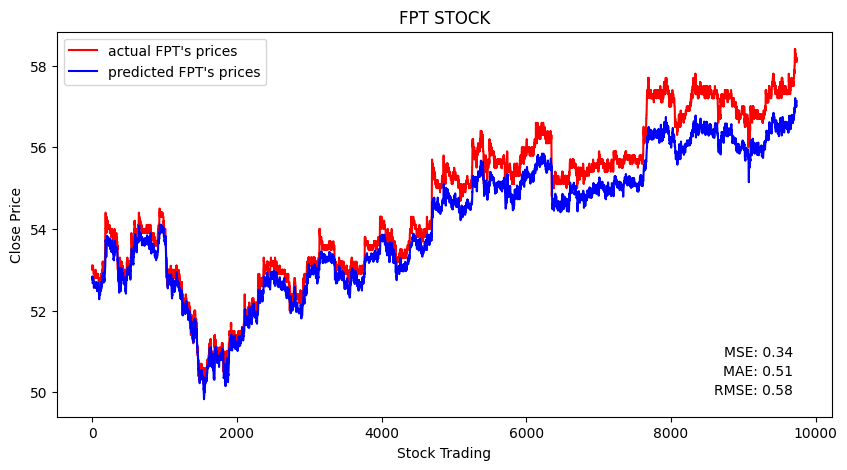
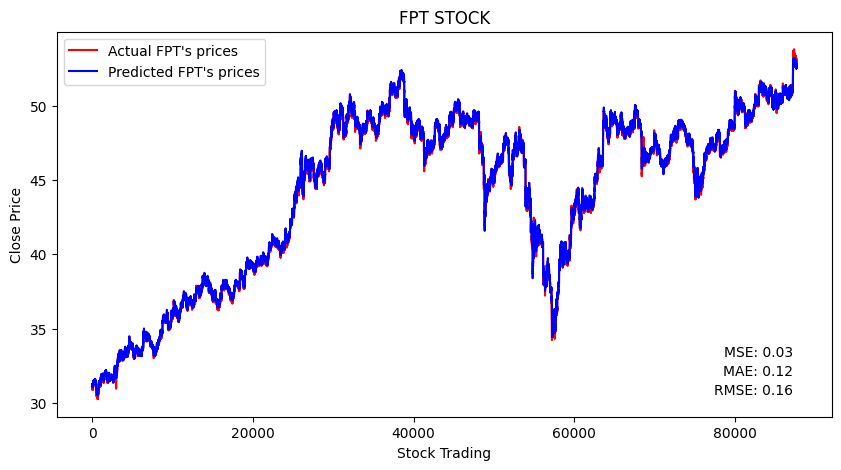
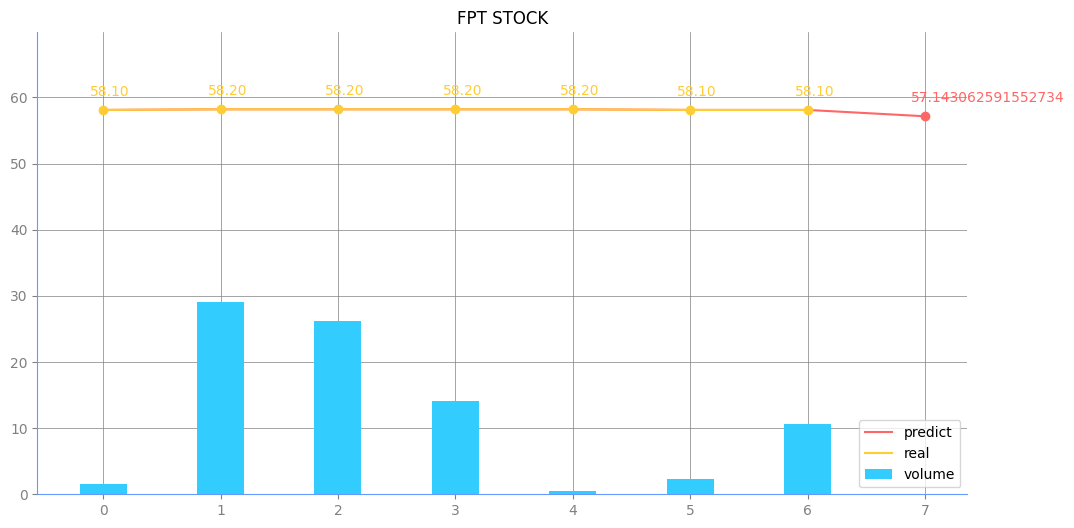

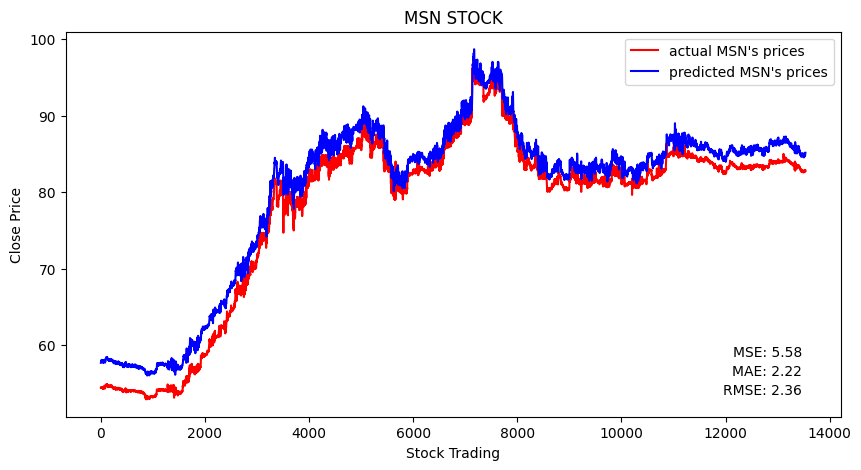
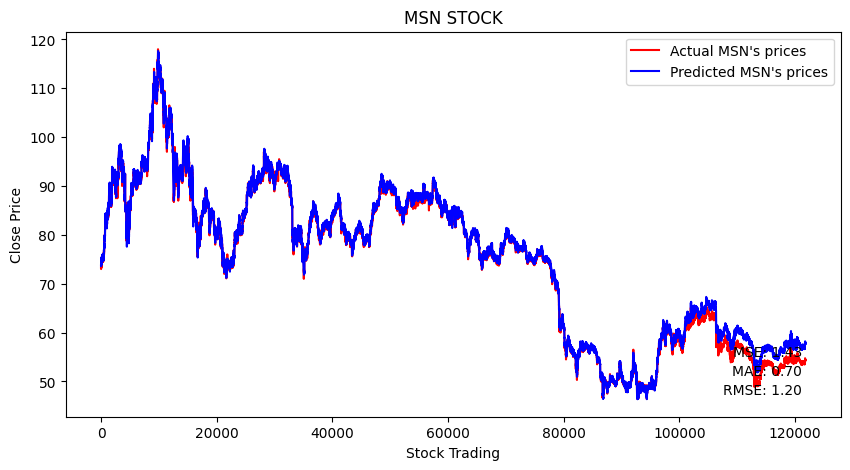
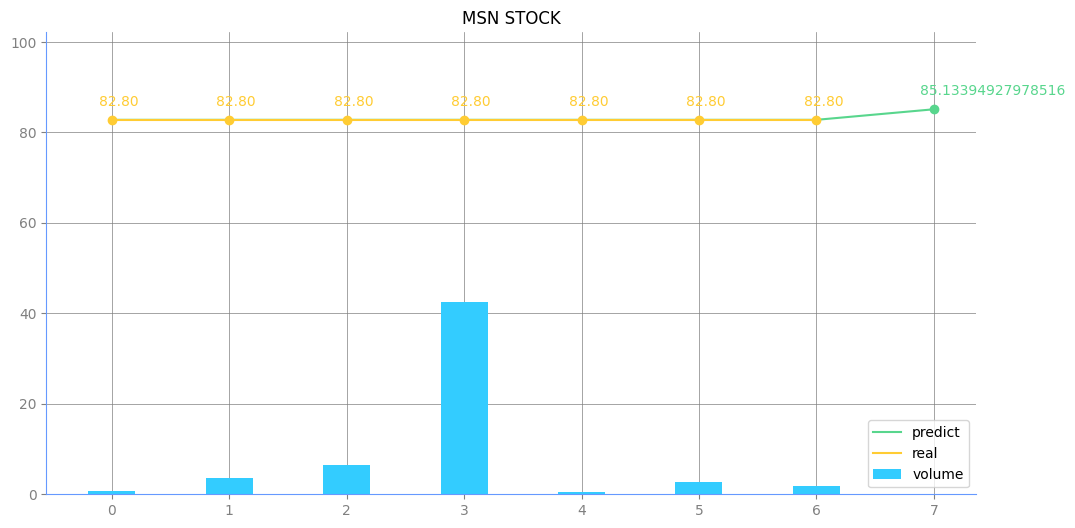

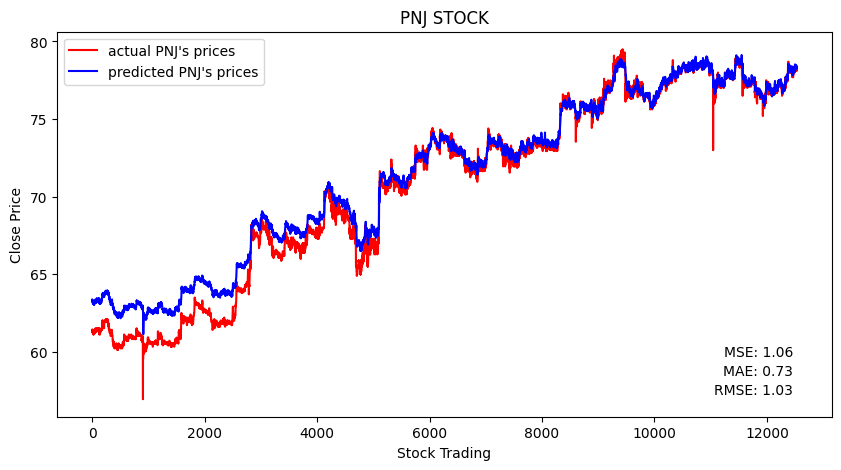
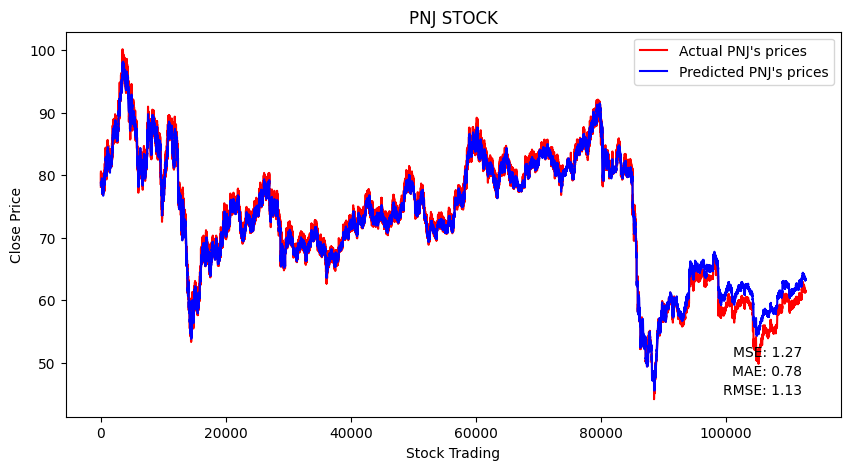
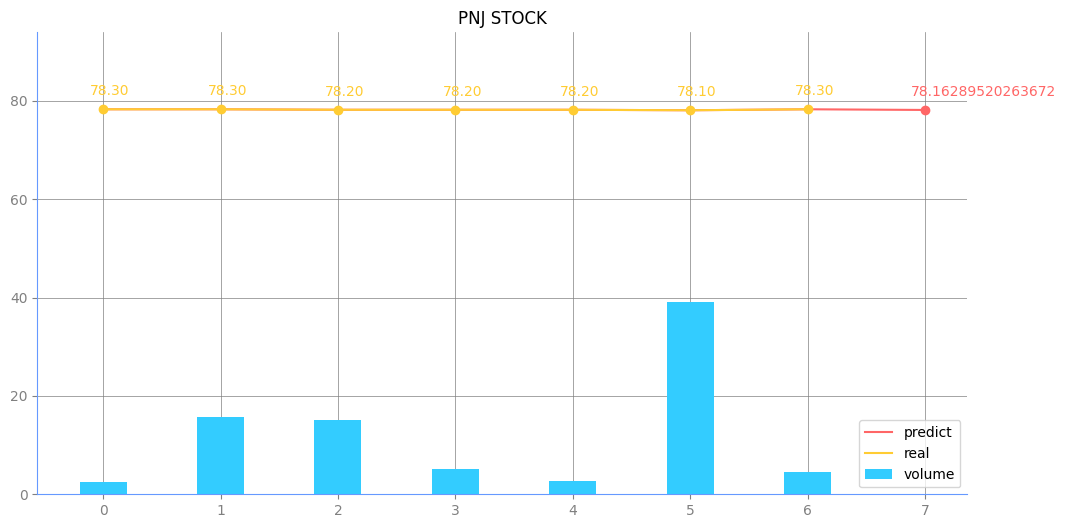

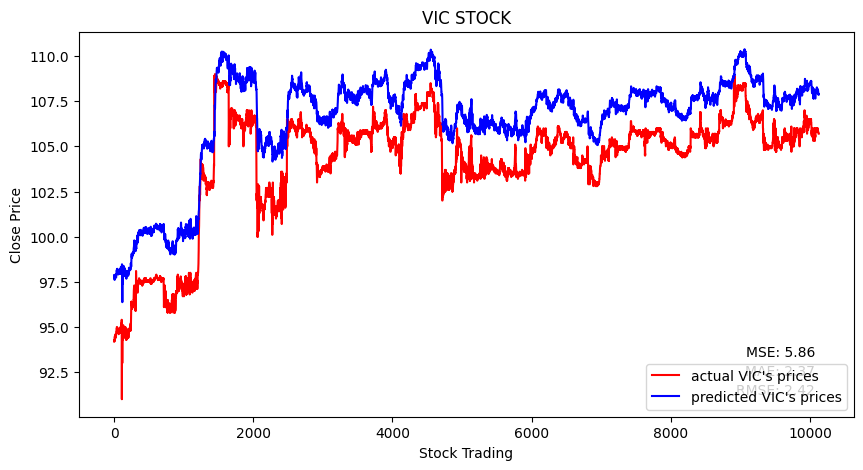
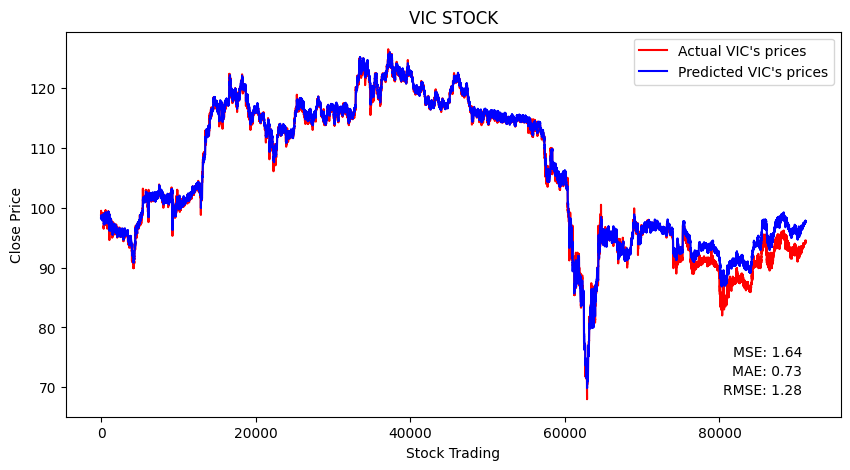
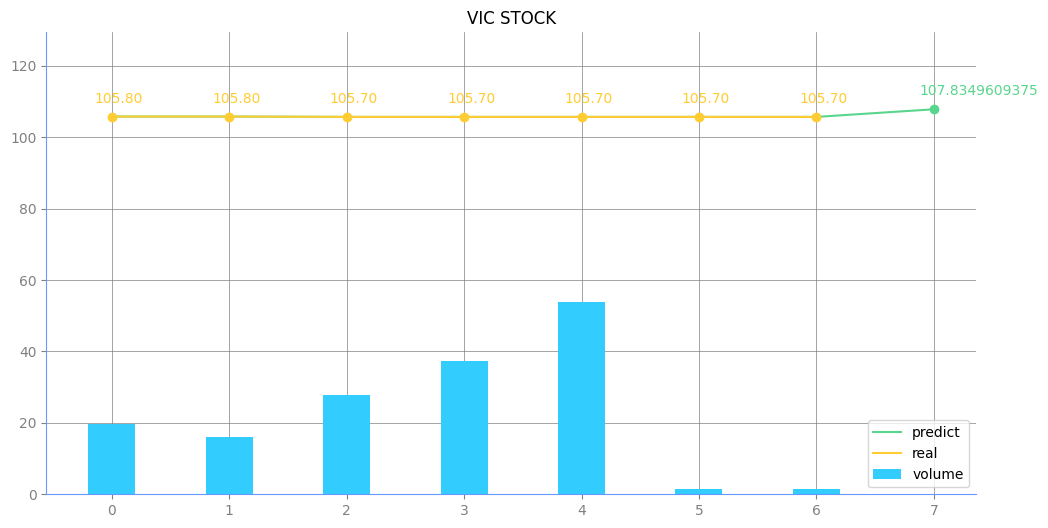